In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.input_area pre {font-family: Consolas; font-size: 12pt; line-height: 140%;}</style>"))
display(HTML("<style>.output_area pre {font-family: Consolas; font-size: 12pt; line-height: 140%;}</style>"))

In [2]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# 4.2) 강남역 맛집 리뷰로 알아보는 감성 분류
### 감성 분류란 문서(텍스트 데이터)를 긍정 또는 부정 의견으로 나누어 분류하는 것.

# [Step1. 크롤링]: 네이버 플레이스 리뷰 크롤링

### [네이버 플레이스 API] 
### 관련도순 상위 100개의 고기집 리스트 정보 API 구하기

In [3]:
import requests
import json

# 네이버 플레이스 API를 호출하기 위한 기본 주소
source_url = "https://store.naver.com/sogum/api/businesses?"

# 검색 규칙 파라미터 추가
url_parameter_start = "start=1"
url_parameter_display = "&display="
url_parameter_query = "&query=강남역+고기집"
url_parameter_sorting = "&sortingOrder=precision"
url_concat = source_url + url_parameter_start + \
            url_parameter_display + str(100) + url_parameter_query + url_parameter_sorting
    
# 반환받은 API 데이터에 json.loads 함수 사용
json_data = requests.get(url_concat).text
restaurant_list_data = json.loads(json_data)

# 관련도순 상위 100개의 고기집 리스트 정보 출력
print(str(restaurant_list_data)[:100]+"...")

{'query': {'select': '1', 'item': [{'rank': '1', 'region_keyword': '강남역', 'region_type': 'favor', 'r...


### 리뷰데이터가 아직 없으므로 랭킹 목록의 상세 페이지로 이동해야함.

In [4]:
restaurant_id_list = []

# 100개씩의 API 호출 결과를 10번 가져온다.
for start_idx in [1, 101, 201, 301, 401, 501, 601, 701, 801, 901]:
    
    # 네이버 플레이스 API를 호출하기 위한 기본 주소
    source_url = "https://store.naver.com/sogum/api/businesses?"
    
    # 검색 규칙 파라미터 추가
    url_parameter_start = "start=" + str(start_idx)
    url_parameter_display = "&display="
    url_parameter_query = "&query=강남역+고기집"
    url_parameter_sorting = "&sortingOrder=precision"
    url_concat = source_url + url_parameter_start + \
                url_parameter_display + str(start_idx+99) + url_parameter_query + url_parameter_sorting
    print("request_url:", url_concat)
    json_data = requests.get(url_concat).text

    restaurant_list_data = json.loads(json_data)

    # 크롤링에 필요한 각 리뷰 상세 페이지의 id 추출
    for restaurant in restaurant_list_data['items']:
        if 'moreBookingReviewsPath' in restaurant:
            restaurant_id_list.append(restaurant['id'])

restaurant_id_list = list(set(restaurant_id_list))

request_url: https://store.naver.com/sogum/api/businesses?start=1&display=100&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=101&display=200&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=201&display=300&query=강남역+고기집&sortingOrder=precision
request_url: https://store.naver.com/sogum/api/businesses?start=301&display=400&query=강남역+고기집&sortingOrder=precision


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

### [맛집 리뷰 정보 크롤링]

In [5]:
import requests
from bs4 import BeautifulSoup
import re

In [6]:
columns = ['score', 'review']
df = pd.DataFrame(columns=columns)
df

,score,review


In [7]:
# 리뷰 상세 페이지의 기본 주소
source_url_head = "https://store.naver.com/restaurants/detail?id="
source_url_tail = "&tab=bookingReview#_tab"

for idx in range(0, len(restaurant_id_list)):
    print("Crawl", str(int(idx/len(restaurant_id_list)*100)), "% complete..")
    
    # 앞서 추출한 리뷰 상세 페이지의 id를 기본 주소의 파라미터로 추가
    req = requests.get(source_url_head + str(restaurant_id_list[idx]) + source_url_tail)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    review_area = soup.find(name="div", attrs={"class":"review_area"})

    # 리뷰가 없는 페이지는 아무 작업도 수행하지 않는다.
    if review_area is None:
        continue

    # 개발자 도구로 살펴본 html 구조에서 리뷰의 점수, 텍스트 부분을 추출
    review_list = review_area.find_all(name="div", attrs={"class":"info_area"})
    for review in review_list:
        score = review.find(name="span", attrs={"class":"score"}).text
        review_txt = review.find(name="div", attrs={"class":"review_txt"}).text

        # 추출한 리뷰의 점수, 리뷰 텍스트를 데이터프레임으로 병합
        row = [score, review_txt]
        series = pd.Series(row, index=df.columns)
        df = df.append(series, ignore_index=True)
print("Crawl 100 %", "complete")

Crawl 0 % complete..
Crawl 1 % complete..
Crawl 3 % complete..
Crawl 5 % complete..
Crawl 7 % complete..
Crawl 8 % complete..
Crawl 10 % complete..
Crawl 12 % complete..
Crawl 14 % complete..
Crawl 16 % complete..
Crawl 17 % complete..
Crawl 19 % complete..
Crawl 21 % complete..
Crawl 23 % complete..
Crawl 25 % complete..
Crawl 26 % complete..
Crawl 28 % complete..
Crawl 30 % complete..
Crawl 32 % complete..
Crawl 33 % complete..
Crawl 35 % complete..
Crawl 37 % complete..
Crawl 39 % complete..
Crawl 41 % complete..
Crawl 42 % complete..
Crawl 44 % complete..
Crawl 46 % complete..
Crawl 48 % complete..
Crawl 50 % complete..
Crawl 51 % complete..
Crawl 53 % complete..
Crawl 55 % complete..
Crawl 57 % complete..
Crawl 58 % complete..
Crawl 60 % complete..
Crawl 62 % complete..
Crawl 64 % complete..
Crawl 66 % complete..
Crawl 67 % complete..
Crawl 69 % complete..
Crawl 71 % complete..
Crawl 73 % complete..
Crawl 75 % complete..
Crawl 76 % complete..
Crawl 78 % complete..
Crawl 80 % compl

In [8]:
df.head()

,score,review
0,5,일하시는 직원분들도 너무 친절하시고🥰\n셀프바 이용 맘에 듦😻\n후식 free 아슈...
1,5,직원 분들도 너무 친절하시고 맛있었어요!!
2,5,소고기 다양한 부위를 무한대로 먹을 수 있는 곳이었어요! 가성비 굿입니다!
3,5,나만가고싶다..
4,5,가성비로는 정말 좋아요. 3-4번 정도 리필 한 거 같구요. 배 터지게 먹었어요. ...


In [9]:
# 4점 이상의 리뷰는 긍정 리뷰, 3점 이하의 리뷰는 부정 리뷰로 평가
df['y'] = df['score'].apply(lambda x: 1 if int(float(x)) > 3 else 0)
print(df.shape)
df.head()

(469, 3)


,score,review,y
0,5,일하시는 직원분들도 너무 친절하시고🥰\n셀프바 이용 맘에 듦😻\n후식 free 아슈...,1
1,5,직원 분들도 너무 친절하시고 맛있었어요!!,1
2,5,소고기 다양한 부위를 무한대로 먹을 수 있는 곳이었어요! 가성비 굿입니다!,1
3,5,나만가고싶다..,1
4,5,가성비로는 정말 좋아요. 3-4번 정도 리필 한 거 같구요. 배 터지게 먹었어요. ...,1


In [10]:
df.to_csv("review_data.csv", index=False)
df = pd.read_csv("review_data.csv")

# [Step2. 전처리] : TF-IDF를 이용한 핵심어 추출
### [형태소 추출하기]
##### 한글 텍스트로 전처리

In [56]:
import re

# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    # 한글의 정규표현식으로 한글만 추출
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')
    result = hangul.sub('', text)
    return result

In [57]:
# 함수를 적용하여 리뷰에서 한글만 추출
df['ko_text'] = df['review'].apply(lambda x: text_cleaning(x))
del df['review']
df.head()

,score,y,ko_text
0,5.0,1,분위기 맛 서비스 최고
1,5.0,1,곱창 맛집 갈때마다 만족스러운 곱창집입니다 치즈 볶음밥도 맛있었어요
2,5.0,1,역시 곱창은 강남곱 ㅠㅠ 소주 부르는맛이예요오늘 비도오는데 제대로 배터지게 먹고왓어...
3,1.5,0,음식은 평범하나 직원들이 매우 불친절합니다문래 곱 너무 맛있게 먹었어서 일부러 찾아...
4,5.0,1,모둠이랑 라면 다 너무너무 맜있어요사람들이 많으니 꼭 미리 예약하고 가세요


##### 형태소 단위로 추출

In [58]:
!set java_home=C:\Program Files\Java\jdk-14.0.2

In [59]:
!pip install konlpy

You are using pip version 9.0.1, however version 20.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [60]:
from konlpy.tag import Okt

In [61]:
# konlpy라이브러리로 텍스트 데이터에서 형태소를 추출
def get_pos(x):
    tagger = Okt()
    pos = tagger.pos(x)
    pos = ['{}/{}'.format(word,tag) for word, tag in pos]
    return pos

# 형태소 추출 동작 테스트
result = get_pos(df['ko_text'][1])
print(result)

['곱창/Noun', '맛집/Noun', '갈/Verb', '때/Noun', '마다/Josa', '만족스러운/Adjective', '곱창/Noun', '집/Noun', '입니다/Adjective', '치즈/Noun', '볶음밥/Noun', '도/Josa', '맛있었어요/Adjective']


### [분류 모델의 학습 데이터로 변환하기]
##### corpus index 생성하기
    CountVectorizer 클래스의 tokenizer 파라미터는 텍스트 데이터의 전처리 방식을 입력하는 것이고, 이 객체에 df['ko_text'].tolist()을 입력값으로 fit_transform을 실행하면 학습 데이터셋을 생성할 수 있다.

In [62]:
from sklearn.feature_extraction.text import CountVectorizer

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_pos(x))
X = index_vectorizer.fit_transform(df['ko_text'].tolist())

In [64]:
X.shape

(472, 2413)

In [68]:
#피처 생성에 사용된 말뭉치
#ex) '분위기' 형태소를 포함한 텍스트라면 1072번 피처의 벡터값은 1
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'분위기/Noun': 1072, '맛/Noun': 766, '서비스/Noun': 1172, '최고/Noun': 2098, '곱창/Noun': 190, '맛집/Noun': 807,..


In [69]:
#'분위기', '맛', '서비스', '최고' 라는 4개의 형태소로 구성된 텍스트 데이터가 있다고 할 때, 변환된 학습 데이터셋에서는 2098, 1172, 766, 1072번 위치의 X피처가 1로 채워진 데이터가 된다.
print(df['ko_text'][0])
print(X[0])

분위기 맛 서비스 최고
  (0, 2098)	1
  (0, 1172)	1
  (0, 766)	1
  (0, 1072)	1


### 텍스트 데이터에 중복되는 형태소가 있다면? => 이를 해결하기 위해 TF-IDF(Term Frequency - Inverse Document Frequency) 사용
### TF-IDF : 다른 문서들에서는 등장하지 않았지만 현재 문서에는 많이 등장하는 단어를 의미하며, 그 단어가 현재 문서에서 얼마나 중요한지를 피처로 나타낼 수 있는 방법
    ex) 1번 텍스트에서 '맛집'이라는 단어가 3번, 모든 데이터에서 '맛집'이 10번 등장한다고 할 때, 1번 문서에서 '맛집'의 TF 값은 3, IDF 값은 0.1

In [70]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [71]:
print(X.shape)
print(X[0])

(472, 2413)
  (0, 1072)	0.5775860694563271
  (0, 766)	0.3924161043407496
  (0, 1172)	0.43081880116706756
  (0, 2098)	0.571663444681389


----
# [Step3. 분류] : 긍정 부정 리뷰 분류하기
### [분류 모델링] - 분류 모델 학습
##### 데이터셋 분리

In [85]:
from sklearn.model_selection import train_test_split

y = df['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(330, 2413)
(142, 2413)


##### Logistic Regression

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.89
Precision : 0.887
Recall : 1.000
F1 : 0.940


### 위 실행 결과를 보면, 대부분의 평가 수치가 매우 높다. 이렇게 비정상적으로 높은 경우, 모델의 평가방법이나 과정을 의심해볼 필요가 있다.

In [87]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix 출력
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[  0  16]
 [  0 126]]


### 이 분류 모델은 모든 데이터를 '1'로 예측하고 있다. 모델이 하나의 결과만을 예측하도록 잘못된 학습을 한 것이다. 이를 '클래스의 불균형 문제'라고 한다.
### 이는 데이터의 Positive sample(1)과 Negative sample(0)의 비율이 크게 차이나는 경우에 발생. 적절한 샘플링 방법을 통해 해결해야함.

### [분류 모델 개선]
##### 클래스 불균형 문제 해결하기

In [88]:
# y가 0과 1을 각각 얼마나 가지고 있는지 확인
df['y'].value_counts()

1    422
0     50
Name: y, dtype: int64

In [89]:
# 1:1 비율로 랜덤 샘플링을 수행 - y가 1, 0인 샘플을 임의로 50개씩 추출
positive_random_idx = df[df['y']==1].sample(50, random_state=30).index.tolist()
negative_random_idx = df[df['y']==0].sample(50, random_state=30).index.tolist()

In [90]:
# 랜덤 데이터로 데이터셋을 나눈다. - 다시 학습 데이터셋 70개, 테스트 데이터셋 30개로 분리한다.
random_idx = positive_random_idx + negative_random_idx
sample_X = X[random_idx, :]
y = df['y'][random_idx]
x_train, x_test, y_train, y_test = train_test_split(sample_X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(70, 2413)
(30, 2413)


----
##### Logistic Regression 다시 학습

In [91]:
# 로지스틱 회귀모델을 다시 학습
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 학습한 모델을 테스트 데이터로 평가
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.60
Precision : 0.520
Recall : 1.000
F1 : 0.684


In [92]:
# Confusion matrix 출력
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[ 5 12]
 [ 0 13]]


### 이전보다 모델의 정확도는 떨어졌지만, 납득할 수 있을 정도의 성능으로 변했다. Confusion Matrix에서도 0과 1 두 클래스를 비슷한 비율로 예측하고 있다.
### 이처럼 분류 모델의 평가 척도는 데이터셋의 샘플링 방법에 따라 성능과 기준이 달라질 수 있다.

----
# [Step4. 활용] : 중요 키워드 분석
### [회귀 모델의 피처 영향력 추출]
#### 양수인 피처들은 리뷰에서 긍정적으로 판단되는 형태소이며, 음수인 피처들은 리뷰에서 부정적으로 판단되는 형태소이다.

<Container object of 2413 artists>

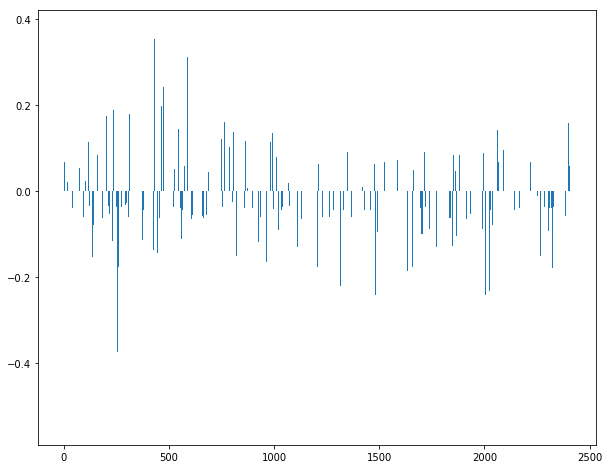

In [93]:
# 학습한 회귀 모델의 계수를 출력
plt.rcParams['figure.figsize'] = [10, 8]
plt.bar(range(len(lr.coef_[0])), lr.coef_[0])

### [중요 피처의 형태소]

### 긍정 형태소와 부정 형태소를 출력하기 위해 계수를 기준으로 형태소를 정렬 -> 정렬된 벡터는 index_vectorizer 객체에 다시 결과를 맵핑 -> 계수가 높은 순서대로 형태소 출력

In [94]:
# 긍정 형태소와 부정 형태소를 출력하기 위해 계수를 기준으로 형태소를 정렬. 
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(0.37485737997848656, 766), (0.3686337372925578, 329), (0.3523885195598684, 431), (0.34874013867657605, 9), (0.34470989169585065, 562)]
[(-0.40102720060539343, 172), (-0.40481133247499834, 739), (-0.4250315872991918, 733), (-0.46615910635415037, 1342), (-0.5445990721836287, 1633)]


In [95]:
# 회귀 모델의 계수를 높은 순으로 정렬
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [96]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 한다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과 출력. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있다.
print(str(invert_index_vectorizer)[:100]+'..')

{1072: '분위기/Noun', 766: '맛/Noun', 1172: '서비스/Noun', 2098: '최고/Noun', 190: '곱창/Noun', 807: '맛집/Noun',..


In [97]:
# 상위 20개 긍정 형태소를 출력
for coef in coef_pos_index[:20]:
    print(invert_index_vectorizer[coef[1]], coef[0])

맛/Noun 0.37485737997848656
깔끔하고/Adjective 0.3686337372925578
너무/Adverb 0.3523885195598684
ㅎㅎ/KoreanParticle 0.34874013867657605
도/Josa 0.34470989169585065
최고/Noun 0.3404222944286197
조아용/Adjective 0.3396258204608534
되게/Adverb 0.310182933546223
분위기/Noun 0.300846445173364
도/Noun 0.284396445506478
좋았습니다/Adjective 0.28103511119193253
까지/Josa 0.2699281405711296
갑니다/Verb 0.2690114407058459
친절하십니다/Adjective 0.2635644899297846
엄청/Adverb 0.2619901217160583
ㅠ/KoreanParticle 0.2567546593357127
인분/Noun 0.2524449164686272
ㅎㅎㅎ/KoreanParticle 0.2443987661689795
늘/Noun 0.24072738270365965
잇어요/Verb 0.23495170427282683


In [98]:
# 상위 20개 부정 형태소를 출력
for coef in coef_pos_index[-20:]:
    print(invert_index_vectorizer[coef[1]], coef[0])

못/VerbPrefix -0.21999059885352532
아닌건/Adjective -0.22193298042578927
비싸고/Adjective -0.22193298042578927
짠듯/Verb -0.23400500402355393
질/Noun -0.24210780136478363
에어컨/Noun -0.2423433009888524
북적/Noun -0.24636279243367815
가/Josa -0.25286201638413075
맛있었습니다/Adjective -0.2838062042298582
이/Josa -0.28408568905945564
에/Josa -0.30366412428854245
아쉽습니다/Adjective -0.3296718175883455
자리/Noun -0.3446636114536559
별로/Noun -0.350073283111719
굳/Adjective -0.37405544841310945
고기/Noun -0.40102720060539343
만족했습니다/Adjective -0.40481133247499834
만족합니다/Adjective -0.4250315872991918
안/VerbPrefix -0.46615910635415037
은/Josa -0.5445990721836287


### `[미니 퀴즈 - 4.3]`
- `피처 영향력에 따라 정렬된 형태소에서, 품사별 긍정 형태소 10개와 부정 형태소 10개를 탐색해 보세요.` 
    - “/”로 구분되어있는 정보를 활용하여 품사별 형태소를 추출할 수 있습니다.

In [107]:
noun_list = []
adj_list = []
for coef in coef_pos_index:
    category = invert_index_vectorizer[coef[1]].split('/')[1]
    if category == 'Noun':
        noun_list.append((invert_index_vectorizer[coef[1]], coef[0]))
    elif category == 'Adjective':
        adj_list.append((invert_index_vectorizer[coef[1]],coef[0]))

In [109]:
noun_list[:10]

[('맛/Noun', 0.37485737997848656),
 ('최고/Noun', 0.3404222944286197),
 ('분위기/Noun', 0.300846445173364),
 ('도/Noun', 0.284396445506478),
 ('인분/Noun', 0.2524449164686272),
 ('늘/Noun', 0.24072738270365965),
 ('사람/Noun', 0.22182703268100742),
 ('집/Noun', 0.2150393976860301),
 ('굿/Noun', 0.19773332954744902),
 ('매장/Noun', 0.19754104725308308)]

In [110]:
adj_list[:10]

[('깔끔하고/Adjective', 0.3686337372925578),
 ('조아용/Adjective', 0.3396258204608534),
 ('좋았습니다/Adjective', 0.28103511119193253),
 ('친절하십니다/Adjective', 0.2635644899297846),
 ('괜찮아요/Adjective', 0.2272789640944945),
 ('더웠어요/Adjective', 0.1940388835936287),
 ('좋고/Adjective', 0.18276993093587138),
 ('괜찮네요/Adjective', 0.17323798931536477),
 ('입니다요/Adjective', 0.16749105771606543),
 ('좋네요/Adjective', 0.15574493631308606)]